# Part 1: Integer Programming

Operations research often involves models where you need to make discrete decisions. 

Suppose Iain wants to carry items to the pawn shop to get some extra cash. He has $N$ items, each with a weight $w_i$ and a price $p_i$. Iain hasn't been to the gym lately, so he can only carry $C$ kilos. How does he choose what to bring with him?

We can model this as an integer optimization problem:

\begin{align*}
\max& \sum_{i=1}^N p_i x_i \\
\text{s.t.}& \sum_{i=1}^N w_i x_i \leq C \\
& x_i \in \{0,1\} \quad \forall i = 1,\ldots,N
\end{align*}


## Example

In particular, consider the following (small) knapsack problem:

\begin{align*}
    \max\:& x + y \\
    \text{s.t.}\:& x + 2y \leq 1.5 \\
    & x, y \in \{0,1\}
\end{align*}

How would you solve this? 

In [2]:
using JuMP, Gurobi
knapsackModel=Model(solver=GurobiSolver(Presolve=0))
@variable(knapsackModel, x, Bin)
@variable(knapsackModel, y, Bin)
@constraint(knapsackModel, x+2*y<=1.5)
@objective(knapsackModel, Max, x+y)
solve(knapsackModel)
println("X is: ", getvalue(x), " Y is: ", getvalue(y))

┌ Warning: Deprecated syntax `implicit assignment to global variable `#1###368``.
│ Use `global #1###368` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `#7###369``.
│ Use `global #7###369` instead.
└ @ nothing none:0


Academic license - for non-commercial use only
Optimize a model with 1 rows, 2 columns and 2 nonzeros
Variable types: 0 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 2 integer (2 binary)

Root relaxation: cutoff, 0 iterations, 0.00 seconds

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 12 (of 12 available processors)

Solution count 1: 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.000000000000e+00, best bound 1.000000000000e+00, gap 0.0000%
X is: 1.0 Y is: -0.0


## Branch and Bound Tree

The simple way is just to consider each possible value for $x$ and $y$ and compare the cost.

![alt text](img/tree_1.png)

In the general case, this would lead to $2^N$ possible collections of items. After Iain has weighed all of them (and verified that he can lift them at once), he just chooses the best set.


Let's visualize this approach as a search tree:

![alt text](img/tree_2.png)

It's rooted at what we call the _relaxation_: none of variables have integrality enforced. As we go down leaves of the tree, we add pick a variable to _branch_ on, and create two descended nodes that fix that variable to one of its possible values. If we follow the tree all the way to the bottom, we reach our enumeration from before.

As we go down the arcs of the tree we restrict our problem more and more, we must have that:

>If node ``q`` is descended from node ``p``, we must have that the optimal cost of subproblem ``q`` is no more than that for node ``p``

This leads us to a powerful tool in solving these enumeration problems: 

>If I can show you that the optimal cost for subproblem ``q`` is _less_ than the optimal cost for the original problem, the same is true for any descendent of ``q``. 


That is, we can _prune_ the tree and safely discard some nodes, kind of like this:

![alt text](img/tree_3.png)

## Worked Example

\begin{align*}
    \max\quad& x + y \\
    \text{s.t.}\quad& x + 2y \leq 1.5 \\
    & 0 \leq x, y \leq 1 \\
    & x, y \in \{0,1\}
\end{align*}

What does the relaxation (no integrality restrictions) of this problem look like?

* First, we solve the LP relaxation and get $(x^*,y^*) = (1,0.25)$. 
* This isn't integer feasible, so we branch on $y$. The subproblem with $y = 1$ is infeasible, and the subproblem with $y = 0$ is feasible with solution $(x^*,y^*) = (1,0)$. This is integer feasible, so we update our lower bound. We've also exhausted the tree, so we have our optimal solution!
* The branch-and-bound scheme can end up solving many subproblems, so for it to work well, we need to _prune_ large portions of the tree. 

## Branch and bound
We'll keep track of a global _lower bound_ $LB$ for our problem. Each node ``q`` will have an upper bound $UB_q$ that it inherents from its parent. If we get to the point where we have solved all subproblems (or, ideally, pruned off a great deal of them), we know that we're optimal. To do this we'll also keep track of a list $L$ of subproblems left to solve; initially, it's just the relaxation. The procedure is:

While $L$ is not empty, pick a subproblem ``q`` out of our list $L$ and solve it. 
1. ``if`` ``q`` is infeasible, ``continue``
2. ``if`` the solution is integer feasible, update the lower bound $LB$ if the cost is higher than what we had before
3. ``if``  the relaxation value is less than our global $LB$ ``continue``
4. ``else`` pick a non-integer variable $i$ and _branch_ by adding two subproblems to $L$: 
    * One with $x_i = 0$
    * Another with $x_i = 1$

Branch-and-bound is sometimes called an _implicit enumeration_ scheme because of step 3: we avoid solving any subproblems that we can prove won't produce the optimal solution.

**The "magic" of modern MIP solvers largely comes down to pruning massive portions of the tree. Some of this is essentially beyond your control, but there are four things which you can do.**


## Stuff you should care about
**We care about four distinct attributes:**

1) **Correctness** (Are "feasible" solutions feasible? Are "optimal" solutions optimal?)

2) **Time taken** (fast is every user's favourite feature).

3) **Bound quality** (how good is the lower bound?).

4) **Solution quality** (how good is the best solution identified?)

In the first part of this session, we will focus on attributes 3-4, through the lens of the travelling salesperson problem (TSP), while taking attribute 1 for granted (improving 3-4 improves 2). In part 3 of this session, we will circle back to this idea, and look at attribute 1 more closely. 

**In general, you should try to solve a problem in a quick-and-dirty way, and see which attribute needs working on.**

**E.g, if you find the optimal solution straight away but need lots of time to prove optimality then focus on bound quality.**

# Improving bound quality

One way to improve the bound quality is by adding cuts to a relaxation, such as the LP relaxation.

Cuts are inequalities that are _valid_ (don't cut off any feasible integer points) and _strengthen_ the formulation (chop off some of the region feasible for the relaxation)

Three main types of cuts:

1. General purpose (e.g. CG, split, MIR)
2. Structure-specific (e.g. knapsack cover, clique)
3. Problem-specific (whatever _you_ cook up)

Generally speaking, solvers can add general purpose and structure specific cuts better than we can. However, we are better at adding problem specific cuts. Therefore, when trying to improve bound quality, a good place to start is identifying problem structure which a solver hasn't found, and exploiting this problem structure.

## Improving solution quality

One way to improve the incumbent solution quality is to obtain integer feasible solutions apriori. These can come from:

1. Problem-specific heuristics.
2. Neighborhood search.
3. Rounding or "polishing" existing high-quality solutions.

For instance, if we're solving a knapsack problem, one simple heuristic is to add a _greedy solution_ where you iteratively add the best available item to the sack until you run out of room. This will often be a very good solution, and is a simple example of a problem-specific heuristic scheme.

# The Travelling Salesperson 101

The basic problem is that we are given a set of co-ordinates $(a_i, b_i)_{i=1}^n$ corresponding to a set of $n$ nodes in a graph, and we need to decide which $n$ of the $n^2$ arcs in the graph we will use to tour the graph, wherein we visit each node exactly once, at _minimum_ total cost. Let's formulate this as an integer program!

Let the cities be indexed from 1 to N.
Let $d_{ij}$ be the distance between city $i$ and city $j$.

Decision variables: $x_{ij}=\begin{cases} 1,\quad \text{if city $i$ and city $j$ are adjacent in the shortest tour}\\
0,\quad \text{otherwise.}\end{cases}$

N.B. $x_{ij}$ and $x_{ji}$ are redundant ($x_{ij}=x_{ji}$), so we only define the variable $x_{ij}$ for $i < j$. Then we can formulate the following integer program.

$$
\underset{x}{\min}\ \sum_{i=1}^N\sum_{j=i+1}^N d_{ij}x_{ij} \\
\text{s.t.}\quad 
\sum_{j=i+1}^N x_{ij} + \sum_{j=1}^{i-1}x_{ji} = 2 \quad\forall i, 1\le i \le N \\
x_{ij}\in\{0,1\}\quad\forall i,j \text{ s.t. } 1\le i < j \le N
$$

However, if we attempt to solve this problem, we will find that we get an infeasible solution, with multiple disjoint subtours. 

![alt text](img/tsp1.png)

Yikes! Our formulation is missing something! What are some potential ways to fix it?

One common way is **subtour elimination** constraints, to prevent the final solution from having any small cycles, i.e. cycles that do not include all the nodes.

Given a subtour $S\subset \{1,\ldots,N\}$, a subtour elimination constraint looks like:
$$\sum_{i\in S} \left(\sum_{j\notin S, j > i}x_{ij}+\sum_{j\notin S, j < i}x_{ji}\right) \ge 2$$.

As $N$ grows larger, the number of subtour elimination constraints grows exponentially. It is therefore impractical to add all of these constraints into the model.

Instead, we generate these constraints lazily. Every time Gurobi has an incumbent solution, we find the shortest subtour in the solution, and add a lazy constraint eliminating this particular subtour.

# How do we add lazy constraints? Solver callbacks 101

Some solvers allow you to customize aspects of the solve process in a deeper way than just setting options for these parameters. You can provide code to be run when certain events happen, and the solver **calls back** to these functions to ask what action(s) should be taken. Why might you want to do this? Some situations:

* **Informational Callbacks:** you might want to extract the intermediate solutions found in the branch&bound tree, or other useful information during the solution process, and not work only with the optimal solution.

* **Lazy Constraints:** you might not want to enumerate all of your constraints at the onset, and enforce certain constraints only when they're needed.

We'll explore these cases in this session.

# A TSP solver



We begin by loading the required modules. Note that you can run this code using either CPLEX or Gurobi.

In [3]:
using JuMP
using Gurobi #CPLEX
using Test
using LinearAlgebra
using DelimitedFiles
using Gadfly

┌ Info: Recompiling stale cache file /Users/Ryancw2/.julia/compiled/v0.7/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1185


Next, we define a function to extract a n+1 dimensional vector representing a tour from an n x n symmetric matrix representing a solution provided by a solver.

In [4]:
function extractTour(n, sol)
    tour = [1]  # Start at city 1 always
    cur_city = 1
    while true
        # Look for first arc out of current city
        for j = 1:n
            if sol[cur_city,j] >= 0.5-1e-6
                # Found next city
                push!(tour, j)
                # Don't ever use this arc again
                sol[cur_city, j] = 0.0
                sol[j, cur_city] = 0.0
                # Move to next city
                cur_city = j
                break
            end
        end
        # If we have come back to 1, stop
        if cur_city == 1
            break
        end
    end  # end while
    return tour
end

extractTour (generic function with 1 method)

Next, we define a function which acts as a seperation oracle, which is a fancy way of saying that it either identifies a subtour which should be banned from the set of all possible solutions, or decides that the current solution is optimal.

In [5]:
# Input:
#  n        Number of cities
#  sol      n-by-n 0-1 symmetric matrix representing solution
# Outputs:
#  subtour  n length vector of booleans, true iff in a particular subtour
#  subtour_length   Number of cities in subtour (if n, no subtour found)
function findSubtour(n, sol)
    # Initialize to no subtour
    subtour = fill(false,n)
    #=
    # Always start looking at city 1
    cur_city = 1
    =#
    # Start looking at a random city: much faster because we explore different subtours
    cur_city=rand(1:n)
    subtour[cur_city] = true
    subtour_length = 1
    while true
        # Find next node that we haven't yet visited
        found_city = false
        indices=shuffle(1:n)
        for j = 1:n
            if !subtour[indices[j]]
                if sol[cur_city, indices[j]] >= 1 - 1e-6
                    # Arc to unvisited city, follow it
                    cur_city = indices[j]
                    subtour[indices[j]] = true
                    found_city = true
                    subtour_length += 1
                    break  # Move on to next city
                end
            end
        end
        if !found_city
            # We are done
            break
        end
    end
    return subtour, subtour_length
end

findSubtour (generic function with 1 method)

Next, we define a function which solves TSP, given a matrix of city locations, using an optimization solver.

In [7]:
# Inputs:
#   n       Number of cities
#   cities  n-by-2 matrix of (x,y) city locations
# Output:
#   path    Vector with order to cities are visited in
function solveTSP(n, cities)

    # Calculate pairwise distance matrix
    dist = zeros(n, n)
    for i = 1:n
        for j = i:n
            d = norm(cities[i,1:2] - cities[j,1:2])
            dist[i,j] = d
            dist[j,i] = d
        end
    end

    m = Model(solver=GurobiSolver(TimeLimit=100))
        # =CplexSolver(CPX_PARAM_TILIM=100))
        # =GurobiSolver(TimeLimit=100))

    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[1:n,1:n], Bin)

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    function subtour(cb)
        # Find any set of cities in a subtour
        @time subtour, subtour_length = findSubtour(n, getvalue(x))

        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        @lazyconstraint(cb, arcs_from_subtour >= 2)
    end 

    addlazycallback(m, subtour)
    solve(m)

    return extractTour(n, getvalue(x))
end

solveTSP (generic function with 1 method)

Next, we define a function to plot the solution

In [8]:
plot_instance(pts) = plot(x = pts[1,:], y = pts[2,:], Geom.point, Guide.xlabel(nothing), Guide.ylabel(nothing))
function plot_solution(pts, path, extras = [])
	ptspath = pts[:,path]
	plot(x = ptspath[1,:], y = ptspath[2,:], Geom.point, Geom.path, Guide.xlabel(nothing), Guide.ylabel(nothing), extras...)
end

plot_solution (generic function with 2 methods)

Next, we solve a small 6 city example (which you might recognize from the diagram above) to verify correctness of our code.

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 48 rows, 36 columns and 102 nonzeros
Variable types: 0 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
  0.133350 seconds (338.08 k allocations: 17.028 MiB, 5.47% gc time)
Found heuristic solution: objective 4145.5612435
Presolve removed 42 rows and 21 columns
Presolve time: 0.01s
Presolved: 6 rows, 15 columns, 30 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective 1.694427e+03, 4 iterations, 0.00 seconds
  0.000024 seconds (6 allocations: 912 bytes)


Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41
Add `using Random` to your imports.
  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


  0.000016 seconds (9 allocations: 1.266 KiB)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2494.4271910 2494.42719  0.00%     -    0s

Cutting planes:
  Lazy constraints: 1

Explored 0 nodes (8 simplex iterations) in 0.58 seconds
Thread count was 12 (of 12 available processors)

Solution count 2: 2494.43 4145.56 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.494427191000e+03, best bound 2.494427191000e+03, gap 0.0000%


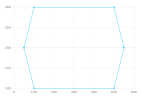

In [9]:
n = 6
cities =    [50 200;
            100 100;
            100 300;
            500 100;
            500 300;
            550 200]
tour = solveTSP(n, cities)

plot_solution(cities', tour)

# A more complicated TSP example
What's the quickest tour around the 48 US state capitals in the mainland US?

In [10]:
# Source: https://people.sc.fsu.edu/~jburkardt/datasets/tsp/att48.tsp
n=48
citiesdata=[6734 1453;
2233 10;
5530 1424;
401 841;
3082 1644;
7608 4458;
7573 3716;
7265 1268;
6898 1885;
1112 2049;
5468 2606;
5989 2873;
4706 2674;
4612 2035;
6347 2683;
6107 669;
7611 5184;
7462 3590;
7732 4723;
5900 3561;
4483 3369;
6101 1110;
5199 2182;
1633 2809;
4307 2322;
675 1006;
7555 4819;
7541 3981;
3177 756;
7352 4506;
7545 2801;
3245 3305;
6426 3173;
4608 1198;
23 2216;
7248 3779;
7762 4595;
7392 2244;
3484 2829;
6271 2135;
4985 140;
1916 1569;
7280 4899;
7509 3239;
10 2676;
6807 2993;
5185 3258;
3023 1942]
tour = solveTSP(n, citiesdata);

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2400 rows, 2304 columns and 6864 nonzeros
Variable types: 0 continuous, 2304 integer (2304 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 8e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 2352 rows and 1176 columns
Presolve time: 0.00s
Presolved: 48 rows, 1128 columns, 2256 nonzeros
Variable types: 0 continuous, 1128 integer (1128 binary)
  0.000047 seconds (8 allocations: 20.375 KiB)

Root relaxation: objective 6.333851e+04, 74 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 63338.5149    0   14          - 63338.5149      -     -    0s
  0.000046 seconds (9 allocations: 20.906 KiB)
  0.000054 seconds (21 allocation

Plot the optimal tour

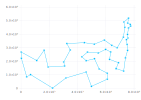

In [11]:
plot_solution(citiesdata', tour)

# A larger-scale TSP: Routing a Vehicle

Let's try to solve a TSP with 380 cities using the above code.

In [12]:

ludata=readdlm("bcl380tsp.txt")
ludata=ludata[:, 2:3] #drop index

n=380
tour = solveTSP(n, ludata[1:n, :])


Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 145160 rows, 144400 columns and 432820 nonzeros
Variable types: 0 continuous, 144400 integer (144400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve removed 144780 rows and 72390 columns
Presolve time: 0.22s
Presolved: 380 rows, 72010 columns, 144020 nonzeros
Variable types: 0 continuous, 72010 integer (72010 binary)
  0.001745 seconds (8 allocations: 1.115 MiB)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e+00      0s
       1        502   5.0030499e+06   2.2609623e+02      0s
       2       1058   3.1335671e+03   2.5637050e+03      0s

Sifting complete


Root relaxation: objective 3.117876e+03

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/Ryancw2/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212
┌ Warning: Variable value not defined for component of x. Check that the model was properly solved.
└ @ JuMP /Users/Ryancw2/.julia/packages/JuMP/Xvn0n/src/JuMP.jl:475


1-element Array{Int64,1}:
 1

That didn't work very well!

**What went wrong?**

a) TSP is NP-hard, so we can't solve it and we should just give up.

b) **We have been focusing on lower bounds, but we also need good heuristics to get good upper bounds.**


Answer: **(b) [notice that we didn't even find a feasible solution!]**

We will use the package TravelingSalesmanHeuristics.jl to generate a high-quality warm-start. We will also switch to using CPLEX rather than Gurobi here, because Gurobi has issues accepting warm-starts. You can still follow along using Gurobi here, but you may run inton some issues.

In [13]:
#Pkg.clone("https://github.com/evanfields/TravelingSalesmanHeuristics.jl/")
using TravelingSalesmanHeuristics

In [14]:
# Calculate pairwise distance matrix for a heuristic
dist = [norm(ludata[i,:] - ludata[j,:]) for i in 1:n, j in 1:n];

In [15]:
Random.seed!(47)
path, cost=solve_tsp(dist, quality_factor = 100)

  likely near /Users/Ryancw2/.julia/packages/IJulia/DL02A/src/kernel.jl:41


([343, 344, 355, 345, 346, 356, 347, 334, 333, 332  …  379, 380, 374, 375, 354, 331, 340, 341, 342, 343], 1705.0746884947876)

The above solution is pretty good. But we obtain a better solution after injecting the above solution as a warm-start and letting a MIO solver run for 10 hours.

In [17]:
tour=[1, 14, 13, 12, 35, 34, 33, 32, 31, 52, 50, 49, 11, 30, 39, 29, 10, 28, 9, 27, 38, 26, 25, 8, 24, 37, 23, 7, 6, 5, 4, 3, 2, 22, 21, 36, 20, 16, 15, 51, 54, 70, 84, 72, 87, 81, 88, 93, 112, 111, 110, 109, 108, 107, 106, 105, 104, 101, 115, 146, 181, 160, 177, 168, 178, 169, 179, 191, 180, 170, 154, 155, 156, 157, 171, 172, 173, 182, 183, 192, 184, 185, 193, 186, 187, 188, 189, 174, 175, 190, 176, 152, 153, 158, 159, 161, 162, 163, 164, 165, 209, 208, 207, 206, 205, 204, 203, 202, 233, 201, 200, 240, 243, 251, 268, 252, 253, 269, 282, 318, 317, 316, 315, 281, 280, 314, 313, 312, 311, 310, 279, 278, 307, 306, 305, 304, 303, 309, 301, 300, 299, 298, 275, 276, 249, 250, 267, 199, 198, 197, 196, 236, 232, 231, 230, 229, 228, 266, 274, 297, 296, 295, 294, 293, 308, 292, 291, 324, 322, 328, 330, 327, 329, 326, 321, 320, 325, 290, 289, 288, 287, 259, 260, 261, 272, 262, 263, 273, 264, 265, 246, 227, 226, 225, 224, 223, 222, 221, 235, 220, 219, 218, 217, 216, 215, 214, 213, 212, 234, 211, 210, 195, 237, 238, 245, 242, 247, 248, 256, 270, 257, 258, 271, 284, 285, 286, 338, 357, 369, 336, 302, 323, 339, 352, 365, 376, 377, 378, 358, 348, 349, 350, 351, 359, 370, 360, 361, 371, 379, 380, 362, 363, 364, 372, 366, 367, 373, 374, 375, 353, 354, 331, 340, 341, 342, 343, 344, 355, 332, 333, 334, 345, 346, 347, 356, 335, 368, 337, 319, 277, 283, 255, 254, 244, 241, 239, 194, 167, 166, 150, 147, 148, 151, 149, 141, 140, 139, 138, 145, 137, 136, 135, 134, 133, 103, 102, 100, 99, 98, 97, 130, 96, 129, 128, 127, 126, 125, 124, 123, 122, 132, 121, 120, 119, 118, 144, 143, 142, 117, 116, 114, 131, 113, 89, 82, 94, 83, 95, 66, 67, 90, 91, 92, 68, 60, 85, 61, 69, 73, 74, 75, 76, 77, 59, 57, 62, 63, 64, 78, 79, 80, 86, 71, 65, 19, 48, 47, 46, 18, 17, 45, 44, 56, 58, 55, 43, 42, 53, 41, 40, 1]
path=tour;

Let's define a new version of solveTSP which takes a warm start solution, and tunes our solver more cleverly.

In [25]:
using CPLEX
function solveTSP(n, cities)

    # Calculate pairwise distance matrix
    dist = [norm(ludata[i,:] - ludata[j,:]) for i in 1:n, j in 1:n]

    m = Model(solver=CplexSolver(CPX_PARAM_TILIM=100, CPX_PARAM_COVERS =-1,CPX_PARAM_ZEROHALFCUTS=-1, CPX_PARAM_FRACCUTS=-1))

    # x[i,j] is 1 iff we travel between i and j, 0 otherwise. 
    # Although we define all n^2 variables, we will only use the (strict) upper triangle. 
    @variable(m, x[1:n,1:n], Bin)

    # Minimize total length of tour
    @objective(m, Min, dot(dist, x))

    # Make x_ij and x_ji be the same thing (undirectional TSP)
    @constraint(m, x.==x')
    # Don't allow self-arcs, by ensuring diagonal is vector of 0s
    @constraint(m, diag(x).==zeros(n))

    # We must enter and leave every city once and only once
    for i = 1:n
        @constraint(m, sum(x[i,j] for j=1:n) == 2)
    end

    function subtour(cb)
        # Find any set of cities in a subtour
        subtour, subtour_length = findSubtour(n, getvalue(x))
        @show subtour_length
        
        if subtour_length == n
            # This "subtour" is actually all cities, so we are done with this node of the branch and bound tree
            return
        end

        # Subtour found - add lazy constraint
        arcs_from_subtour = zero(AffExpr)
        for i = 1:n
            if subtour[i]
            # If this city isn't in subtour, skip it
                for j = 1:n
                    # Want to include all arcs from this city, which is in the subtour, 
                    # to all cities not in the subtour
                    if (i !=j) && !(subtour[j])
                        # j isn't in subtour
                        arcs_from_subtour += x[i,j]
                    end
                end
            end
        end
        # Add the subtour elimination constraint
        @lazyconstraint(cb, arcs_from_subtour >= 2)
    end 

    addlazycallback(m, subtour)
    setvalue(x, warmstart)
    solve(m)

    return extractTour(n, getvalue(x))
end

solveTSP (generic function with 1 method)

In [23]:
warmstart=zeros(n,n);
for i=1:(size(path,1)-1)
    warmstart[path[i], path[i+1]]=1.0;
    warmstart[path[i+1], path[i]]=1.0;
end
warmstart[path[n-1], path[1]]=1.0;
warmstart[path[1], path[n-1]]=1.0;

Let's verify that the solution obtained earlier from our solver is near-optimal.

In [26]:
tour = solveTSP(n, ludata[1:n, :])

CPXPARAM_TimeLimit                               100
CPXPARAM_Preprocessing_Reduce                    1
CPXPARAM_Preprocessing_Linear                    0
CPXPARAM_MIP_Cuts_Covers                         -1
CPXPARAM_MIP_Cuts_Gomory                         -1
CPXPARAM_MIP_Strategy_CallbackReducedLP          0
CPXPARAM_MIP_Cuts_ZeroHalfCut                    -1
Retaining values of one MIP start for possible repair.
Tried aggregator 2 times.
MIP Presolve eliminated 72770 rows and 380 columns.
Aggregator did 72010 substitutions.
Reduced MIP has 380 rows, 72010 columns, and 144020 nonzeros.
Reduced MIP has 72010 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.23 sec. (179.87 ticks)
Probing time = 0.04 sec. (11.19 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.07 sec. (49.69 ticks)

        Nodes                                         Cuts/
   Nod

┌ Warning: Not solved to optimality, status: UserLimit
└ @ JuMP /Users/Ryancw2/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212


381-element Array{Int64,1}:
  1
 14
 13
 12
 35
 34
 33
 32
 31
 52
 50
 49
 11
  ⋮
 17
 45
 44
 56
 58
 55
 43
 42
 53
 41
 40
  1

Let's visualize the final tour.

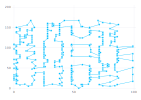

In [27]:
plot_solution(ludata', tour)

# Wrapping-up part (1): The Concorde App
* The code laid out above doesn't scale to n=1000s, because of the way we laid out the problem data, and because we aren't using every trick in the book: e.g., we made Julia compute the full distance matrix, which is expensive.

* The heuristic we are using is also not quite state-of-the-art: it uses 2-opt swaps, but we get better solutions with 2-opt and 3-opt swaps.

* These issues are dealt with in the Concorde TSP code, a state-of-the-art TSP solver which solves TSPs with millions of variables to certifiable optimality by carefully managing its memory and using lots of other "tricks" from the literature. 

**If you have an iPhone, download the (free) Concorde app and try it out!**

**See here: http://www.math.uwaterloo.ca/tsp/iphone/index.html, or the app store.**




# Appendix: Some useful solver parameters [Optional Reading]
Gurobi (and other high-quality solvers such as CPLEX) allow you to tweak a wide range of different parameters; sometimes tuning these can drastically improve performance. It can be kind of intimidating, though: Gurobi has over 100 parameters (and CPLEX has even more!), so which are the important ones?

Some useful ones:

Gurobi: 
* TimeLimit: how long the solver will run before giving up
* MIPGap: termination criterion for relative gap $\frac{UB-LB}{LB}$
* MIPFocus: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution)
* VarBranch: MIP branching strategy (pseudocost/strong branching)
* Cuts: How aggresive we want to be in our cut generation (higher values improve lower bound but might slow overall process).

CPLEX:
* CPX_PARAM_TILIM: how long the solver will run before giving up
* CPX_PARAM_EPOPT: termination criterion for relative gap $\frac{UB-LB}{LB}$
* CPX_PARAM_MIPEMPHASIS: High-level controls on solver priority (proving optimality or increasing bound or finding optimal solution)
* CPX_PARAM_VARSEL: MIP branching strategy (pseudocost/strong branching)
* CPX_PARAM_NODESEL: MIP node selection strategy

Is that it? Well, no, but you probably need domain knowledge about your problem to go much further. 

# Credit

This material is adapted from previous versions of this course, which have been designed by numerous ORC students.